In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.io import imread

from utils import show, show_multiple
from utils import get_splitted_data_with_size, plot_model_history, scale_data, apply_scaling

### Unzip the data on disk

In [2]:
if not os.path.exists('data/cat/'):
    print('Extracting cat image files...')
    zf = zipfile.ZipFile('data/cat.zip')
    zf.extractall('data/')
if not os.path.exists('data/dog/'):
    print('Extracting dog image files...')
    zf = zipfile.ZipFile('data/dog.zip')
    zf.extractall('data/')

Extracting cat image files...
Extracting dog image files...


# I - Introduction to Tensorflow and convolution filters

<img src="../images/standard_vs_depthwise_conv.png" style="width: 850px;"/>

**- Left: standard convolution, the whole kernel is parsing the input tensor for each output channel dimension**

**- Right: depthwise convolution, each slide of the kernel is parsing each input dimension. The result is constructed afterward using a concatenation of the feature maps. That is particularly useful to retrieve a valid RGB image**

#### Sample image example

In [3]:
sample_image = imread("data/panda.jpg")
sample_image = tf.cast(sample_image, tf.float32)  # we will cast it as a tensorflow EagerTensor

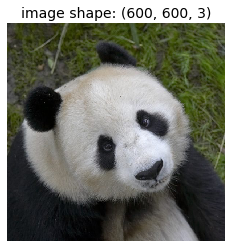

In [4]:
show(sample_image.numpy())

### I - A) Simple box blur kernel

#### 2d convolution with tensorflow:
- https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d
- https://www.tensorflow.org/api_docs/python/tf/nn/conv2d

In [5]:
def conv_2d(x, k, strides, padding, conv_type):
    if conv_type == 'depthwise':
        return tf.nn.depthwise_conv2d(
            x, k, strides=strides, padding=padding
        )
    elif conv_type == 'standard':
        return tf.nn.conv2d(
            x, k, strides=strides, padding=padding
        )   

In [6]:
def visualize_kernel(kernel):
    # move the channel dimension to the first one
    # this way, it is easier to see the spacial organization of the kernel with print
    print(np.transpose(kernel, (2, 0, 1)))

In [7]:
kernel_data = np.ones(shape=(5, 5, 3)).astype(np.float32)
kernel_data = tf.divide(kernel_data, tf.reduce_sum(kernel_data, axis=[0, 1]))
visualize_kernel(kernel_data)

[[[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]

 [[0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]
  [0.04 0.04 0.04 0.04 0.04]]]


Kernel shape: (5, 5, 3, 1)


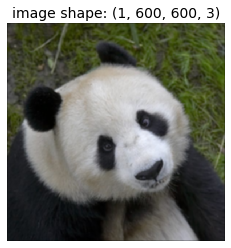

In [9]:
image_batch_expanded = tf.expand_dims(sample_image, axis=0)
kernel_data_expanded = tf.expand_dims(kernel_data, axis=-1)
print('Kernel shape: %s' % str(kernel_data_expanded.shape))
output_image = conv_2d(
    image_batch_expanded, 
    kernel_data_expanded, 
    strides=(1, 1, 1, 1), 
    padding='SAME', conv_type='depthwise'
)
feature_map = output_image.numpy()
show(feature_map)

**Questions**
- Explain what happened here: what transformation has been applied to the image?

### I - B) Identity kernel

In [10]:
kernel_data = np.zeros(shape=(3, 3, 3)).astype(np.float32)
kernel_data[1, 1, :] = 1
visualize_kernel(kernel_data)

[[[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 1. 0.]
  [0. 0. 0.]]]


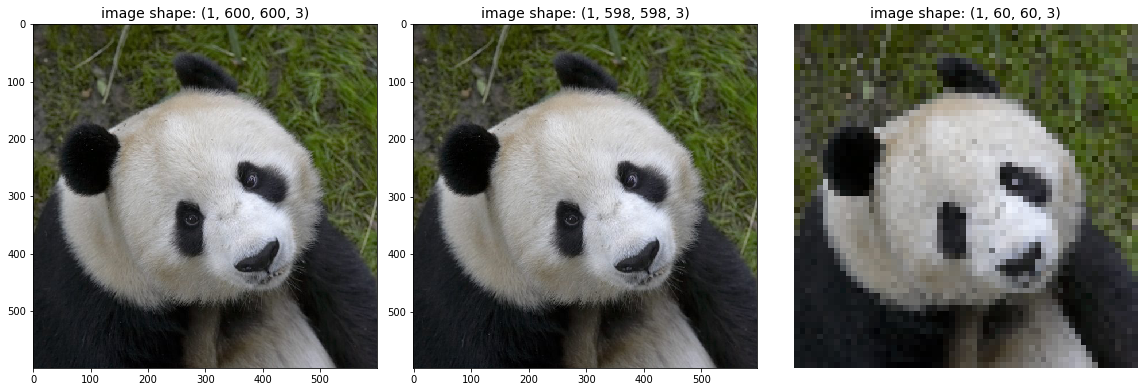

In [11]:
image_batch_expanded = np.expand_dims(sample_image, axis=0)
kernel_data_expanded = np.expand_dims(kernel_data, axis=-1)
features_map = []
for padding, strides in [
    ('SAME', (1, 1, 1, 1)), ('VALID', (1, 1, 1, 1)), ('SAME', (1, 10, 10, 1))
]:
    feature_map = conv_2d(
        image_batch_expanded, kernel_data_expanded, 
        strides=strides, 
        padding=padding, 
        conv_type='depthwise'
    )
    features_map.append(feature_map.numpy())
show_multiple(features_map, figsize=(16, 12))

**Questions**
- Try to modify the strides and the padding type. What are the effects on the final output?

### I - C) Line detection kernel on greyscale transformed image

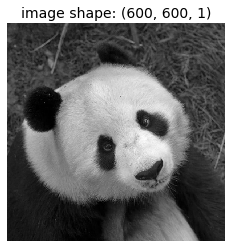

In [12]:
grey_sample_image = tf.expand_dims(tf.reduce_sum(sample_image, axis=2) / 3., axis=-1)
show(grey_sample_image.numpy())

**Exercice**

Try to implement a kernel that does line or edge detection:
- https://en.wikipedia.org/wiki/Kernel_(image_processing)
- https://en.wikipedia.org/wiki/Sobel_operator

In [22]:
# Implement a 3x3 edge detection kernel
line_detection_kernel = np.asarray(
    [
        # TODO:
        [0., -1., 0.],
        [-1., 5., -1.],
        [0., -1., 0.]
    ]
)

kernel_data = tf.expand_dims(line_detection_kernel, axis=-1)
visualize_kernel(kernel_data)

[[[ 0. -1.  0.]
  [-1.  5. -1.]
  [ 0. -1.  0.]]]


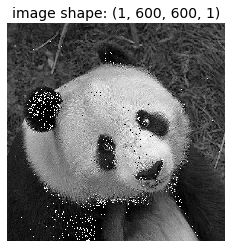

In [23]:
image_batch = tf.expand_dims(grey_sample_image, axis=0)
kernel_expanded = tf.cast(tf.expand_dims(kernel_data, axis=-1), tf.float32)
output_line_detection = conv_2d(
    image_batch, kernel_expanded,
    strides=(1, 1, 1, 1), 
    padding='SAME', 
    conv_type='standard'
)
show(output_line_detection.numpy())

### I - D) Max and average pooling

**Exercice**

Now apply a Max Pooling and an Average Pooling operations on our image.<br/>
- https://www.tensorflow.org/api_docs/python/tf/nn/max_pool
- https://www.tensorflow.org/api_docs/python/tf/nn/avg_pool

Again, try to make fluctuate the `ksize` and `strides` parameters

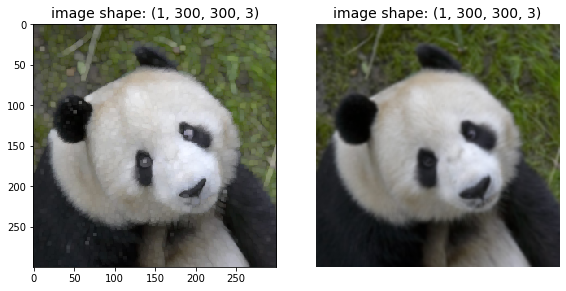

In [26]:
image_batch_expanded = np.expand_dims(sample_image, axis=0)

ksize = 8
strides = 2
padding="SAME"

# TODO:
output_max_pool = tf.nn.max_pool(
    image_batch_expanded,
    ksize=ksize,
    strides=strides,
    padding=padding,
    data_format=None,
    name=None
)

output_avg_pool = tf.nn.avg_pool(
    image_batch_expanded,
    ksize=ksize,
    strides=strides,
    padding=padding,
    data_format=None,
    name=None
)


if output_max_pool is not None and output_avg_pool is not None:
    show_multiple([output_max_pool.numpy(), output_avg_pool.numpy()], figsize=(8, 6))

# II - Training a ConvNet with Keras

### II - A) Load, resize and scale the data

It is advised to fix a relatively small image_size, for instance (32, 32, 3), to avoid suffering from slow calculation

In [27]:
image_size = (32, 32, 3)

classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=image_size, sample_size=10000, test_ratio=0.25, classes=classes, seed=42
)

In [32]:
X_tr.shape, X_val.shape, Y_tr.shape, Y_val.shape

((7500, 32, 32, 3), (2500, 32, 32, 3), (7500,), (2500,))

True label: cat


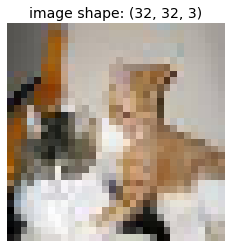

In [29]:
i = np.random.choice(len(X_tr))
show(X_tr[i])
print('True label: {0}'.format(classes[Y_tr[i]]))

In [30]:
X_tr_scaled, X_val_scaled, scaler = scale_data(X_tr, X_val, return_scaler=True)

### II - B) Design and train a ConvNet from scratch

**Exercice**

- Implement a Convolutional Network using the Keras Sequential API
- Typically, you would use series of convolutional blocs: 

`
model.add(Conv2D(output_filter, (kernel_height, kernel_width), padding, input_shape=(input_height, input_width, input_filter)))
model.add(Activation(activation))
model.add(BatchNormalization())
`
- Usually, the output_filter size grows accross the network
- End the network with a `Flatten` layer followed by a final `Dense` layer
- Be careful with the shapes accross the network, the activation functions used, the optimizer, and the loss function
- Don't forget to use Dropout layers to avoid overfitting issues

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

"""
Return a compiled Keras model
"""
def design_and_compile_model():
    model = Sequential()
    # TODO:
    model.add(Conv2D(64, (5, 5), padding="SAME", input_shape=(32, 32, 3)))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    # Compiling the model adds a loss function, optimiser and metrics to track during training
    model.compile(
        optimizer="adam",
        loss="mean_squared_error",
        metrics=["accuracy"]
    )
    
    return model

In [41]:
design_and_compile_model().summary() if design_and_compile_model() else None

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65537     
Total params: 70,657
Trainable params: 70,529
Non-trainable params: 128
_________________________________________________________________


In [42]:
batch_size = 128
num_epochs = 20  # The number of epochs (full passes through the data) to train for

model = design_and_compile_model()

# The fit function allows you to fit the compiled model to some training data
if model:
    model_history = model.fit(
        x=X_tr_scaled, 
        y=Y_tr, 
        batch_size=batch_size, 
        epochs=num_epochs,
        verbose=1,
        validation_data=(X_val_scaled, Y_val)
    )
    print('Training complete')
else:
    model_history = None

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 18s 2ms/sample - loss: 0.4194 - accuracy: 0.5575 - val_loss: 0.4663 - val_accuracy: 0.5072
Epoch 2/20
7500/7500 [==============================] - 16s 2ms/sample - loss: 0.3713 - accuracy: 0.5931 - val_loss: 0.2913 - val_accuracy: 0.5368
Epoch 3/20
7500/7500 [==============================] - 15s 2ms/sample - loss: 0.2903 - accuracy: 0.6387 - val_loss: 0.3372 - val_accuracy: 0.5152
Epoch 4/20
7500/7500 [==============================] - 15s 2ms/sample - loss: 0.2289 - accuracy: 0.6917 - val_loss: 0.2753 - val_accuracy: 0.5240
Epoch 5/20
7500/7500 [==============================] - 15s 2ms/sample - loss: 0.1849 - accuracy: 0.7369 - val_loss: 0.2739 - val_accuracy: 0.5496
Epoch 6/20
7500/7500 [==============================] - 16s 2ms/sample - loss: 0.1549 - accuracy: 0.7799 - val_loss: 0.2541 - val_accuracy: 0.5688
Epoch 7/20
7500/7500 [==============================] - 15s 2ms/sample

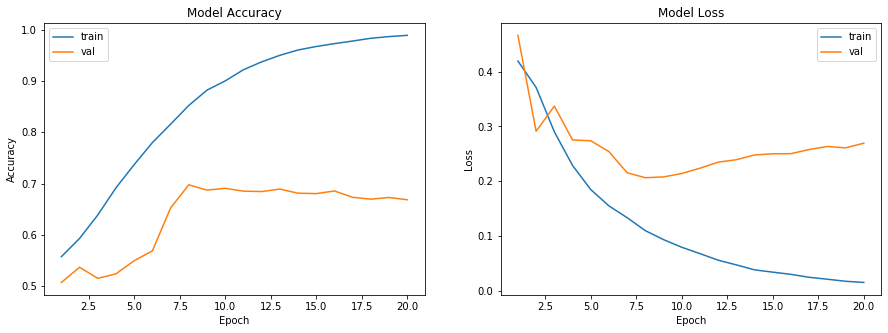

In [43]:
plot_model_history(model_history) if model_history else None

### II - C) Improve it using data augmentation

**Exercice**

- Try to improve the effectiveness of your network using some Data Augmentation
- Basically, it consists in building a `ImageDataGenerator` fitted on your training dataset
- Then you will be able to generate new consistent samples, and refit your model using the `fit_generator` Keras method

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate a ImageDataGenerator object with the right parameters and then fit it on your training dataset
# TODO:

In [24]:
model = design_and_compile_model()
# Fit your model with model.fit_generator() and feed it with data_generator.flow()
# TODO:

In [25]:
plot_model_history(model_history) if model_history else None

# III - Transfer learning

Objectives:
- Classify an image by loading a pre-trained ResNet50 model using Keras Zoo
    - No training required
    - Decode an ImageNet prediction
- Build a headless model and compute representations of images 
    - Retrain a model from representations of images for your own classification task: here cat vs dog dataset

In [26]:
cat_sample_path = "data/cat/cat_1.jpg"
dog_sample_path = "data/dog/dog_1.jpg"
resnet_input_size = (224, 224)

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from skimage.transform import resize
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import decode_predictions

model_ResNet50 = ResNet50(include_top=True, weights='imagenet')
model_ResNet50.summary()

### III - A) Classify of an image using pre-trained weights

**Exercise**
- Open an image, preprocess it and build a batch of 1 image
- Use the model to classify this image
- Decode the predictions using `decode_predictions` from Keras

Notes:
- You may use `preprocess_input` for preprocessing the image. 
- Test your code with `"data/cat/cat_1.jpg"` 
- ResNet has been trained on (width, height) images of (224,224) and range of pixel intensities in `[0, 255]`.
    - [skimage.transform.resize](http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize) has a `preserve_range` keyword useful in that matter 

In [28]:
img = imread(cat_sample_path)
img_resized = resize(img, resnet_input_size, mode='reflect', preserve_range=True)
show(img_resized)

# Use preprocess_input() to apply the same preprocessing as ResNet, 
# get the prediction from the loaded model, and then decode the predictions

# TODO:
decoded_predictions = None

if decoded_predictions:
    for _, name, score in decoded_predictions:
        print(name, score)

### III - B) Build a headless model and compute representations of images

- Model has $177$ layers
- See where we should stop to have the extracted feature and start building a new classficlation model from here

In [29]:
print(len(model_ResNet50.layers))

- Let's remove the last dense classification layer that is specific 
to the image net classes and use the previous layers (after flattening) as a feature extractors
- Use ResNet input layer and last layer of extracted features to build a feature extractor model
    - Use Keras functional API

In [30]:
# Create a truncated Model using ResNet50.input and the before last layer

# TODO:
feat_extractor_model = None

When using this model we need to be careful to apply the same image processing as was used during the training, otherwise the marginal distribution of the input pixels might not be on the right scale:

In [31]:
def preprocess_resnet(x, size):
    x = resize(x, size, mode='reflect', preserve_range=True)
    x = np.expand_dims(x, axis=0)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=0)
    return preprocess_input(x)

This model extracts high level concepts from any image that has been preprocessed like the images ResNet trained on.
The model transforms a preprocessed (224, 224) RGB image into a long vector of activations.
Each activation refers to some concept statistically connected to a bunch of different classes.

In [32]:
cat_img = imread(cat_sample_path)
cat_img_processed = preprocess_resnet(cat_img, resnet_input_size)
if feat_extractor_model:
    cat_representation = feat_extractor_model.predict(cat_img_processed)
    print("Cat deep representation shape: (%d, %d)" % cat_representation.shape)
    cat_representation_df = pd.DataFrame(np.ravel(cat_representation), columns=['cat_deep_features'])
else:
    cat_representation_df = None
cat_representation_df

**Questions**
- What is the number of $0$s in the cat representation vector?
- Can you find any negative values?
- Why are there $0$ values? What does it mean?
- Extract ResNet representations of other dogs and cats. Are the zeros at the same places in vector? Explain why or give an intuition of it

In [33]:
if feat_extractor_model:
    plt.hist(np.where(cat_representation == 0)[1], bins=25)
    plt.title("cat zeros positions")
    plt.show()

    dog_img = imread(dog_sample_path)
    dog_img_processed = preprocess_resnet(dog_img, resnet_input_size)
    dog_representation = feat_extractor_model.predict(dog_img_processed)

    plt.hist(np.where(dog_representation == 0)[1], bins=25)
    plt.title("dog zeros positions")
    plt.show()

### III - C) Retrain a model from computed representations of images

For this session we are going to use the dataset of the dogs-vs-cats we already used in part $2$.

In [34]:
classes = ['cat', 'dog']
X_tr, X_val, Y_tr, Y_val = get_splitted_data_with_size(
    image_size=(224, 224, 3), sample_size=2000, test_ratio=0.25, classes=classes, seed=42
)

**Questions**
- Inference time takes a long time only for $2000$ images. Explain why it would be much faster using a GPU

In [35]:
if feat_extractor_model:
    X_extracted_tr = feat_extractor_model.predict(preprocess_input(X_tr), verbose=1)
    X_extracted_val = feat_extractor_model.predict(preprocess_input(X_val), verbose=1)
    print('Done extracting resnet50 features..')

- Define a classification model fed with the newly created X and Y. <br>Remember that X is now a set of ResNet representations of the images
- Use either functional of sequential Keras apis
- Display training and validation accuracies

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam

# TODO:
transfer_model = None

**Questions**
- How high in validation accuracy did you get? 
- Compare to your previous classification model in part 2. Does it perform worse? Better? Why?
- Did you observe overfitting during training? Why? If yes, what did you do to avoid it?